# CASA0013: Foundations of Spatial Data Science

## Reproducible Analysis

### Student ID: 21047001


### 1. Import packages 


In [20]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### 2. Load London MSOAs Data


#### 2.1. Load MSOA data shapefile

<AxesSubplot:>

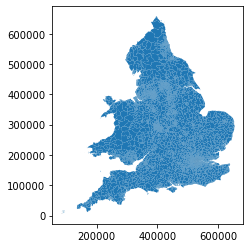

In [49]:
msoas = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V3-shp.zip?raw=true')
# MSOA geopackage source link: 
# https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-boundaries-full-extent-bfe-ew-v3/

msoas.plot()

In [3]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
1220,1221,E02001258,Tameside 030,Tameside 030,396211,393304,-2.05850,53.43651,5.807434e+06,16073.342841,"POLYGON ((394761.894 394479.701, 394801.564 39..."
3637,3638,E02003730,Cambridge 012,Cambridge 012,544877,255684,0.11755,52.18040,7.331295e+06,13693.489501,"POLYGON ((545818.678 257706.721, 545739.625 25..."
3395,3396,E02003485,Milton Keynes 027,Milton Keynes 027,485795,234760,-0.75153,52.00466,1.730800e+06,5238.154557,"POLYGON ((486635.304 234644.861, 486595.344 23..."


In [4]:
for gpkg in [msoas]:
    print(gpkg.crs)

epsg:27700


#### 2.2. Set London Brough Boundaries

In [5]:
boros = gpd.read_file('https://github.com/joeylizh/i2p/blob/main/assessments/coursework3/cw_data/Boroughs.gpkg?raw=true')
# Borough geopackage source link: 
# https://data.london.gov.uk/dataset/london_boroughs

# boros.plot()
boros.shape

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(33, 6)

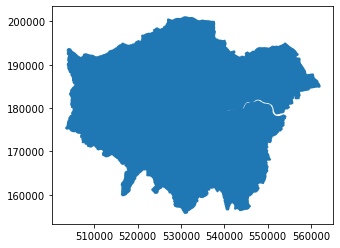

In [6]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# The boundary is buffered by 250m in order to ensure all MSOAs _within_ London can be ontained 

ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

#### 2.3. Set London MSOAs

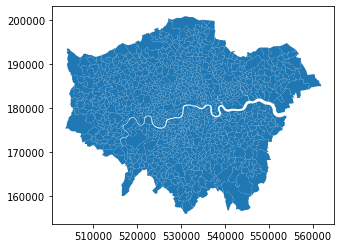

In [7]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

In [8]:
del(msoas)

### 3. Load Cultural Infrastructure Data

#### 3.1. Load cultural infrastructure (culin) csv data

In [9]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/cultural_infrastructure_all_sites.csv'
# Cultural infrastructure source link: 
# https://data.london.gov.uk/dataset/cultural-infrastructure-map

df_culin = pd.read_csv(url, low_memory=False)
df_culin.shape

(10003, 29)

In [16]:
# Clean the data
df_culin.drop(df_culin[((df_culin.latitude.isna())|(df_culin.longitude.isna()))].index, axis=0, inplace=True)
df_culin.drop(df_culin[((df_culin.latitude < 40)|(df_culin.longitude > 1))].index, axis=0, inplace=True)
print(df_culin.shape)

(10003, 29)


In [17]:
df_culin.columns

Index(['BOROUGH', 'Cultural Venue Type', 'additional_contact_name', 'address1',
       'address2', 'address3', 'alternativenames', 'borough_code',
       'borough_name', 'building_name', 'contact_name', 'easting',
       'fid_london_ward', 'greenflagcommunityaward', 'gss_code', 'latitude',
       'longitude', 'northing', 'os_addressbase_uprn', 'rm_organisation_name',
       'runtime', 'site_name', 'ward', 'ward_2018_code', 'ward_2018_name',
       'ward_code', 'ward_code_2018', 'ward_name_2018', 'website'],
      dtype='object')

#### 3.2. Convert the dataframe into a GeoDataFrame(gdf)

<AxesSubplot:>

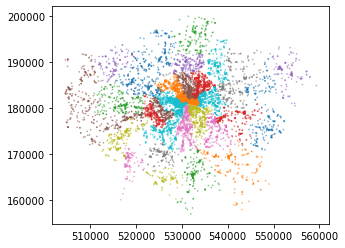

In [45]:
gdf_culin = gpd.GeoDataFrame(df_culin, geometry=gpd.points_from_xy(df_culin.longitude, df_culin.latitude,
                                                       crs='epsg:4326'))
gdf_culin = gdf_culin.to_crs('epsg:27700')
gdf_culin.plot(column='BOROUGH', markersize=0.5, alpha=0.5)

#### 3.3. Check problematic listings

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

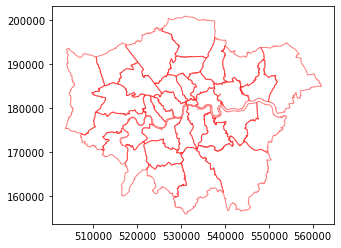

In [28]:
ax = gdf_culin[gdf_culin.BOROUGH.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

#### 3.7. Check results

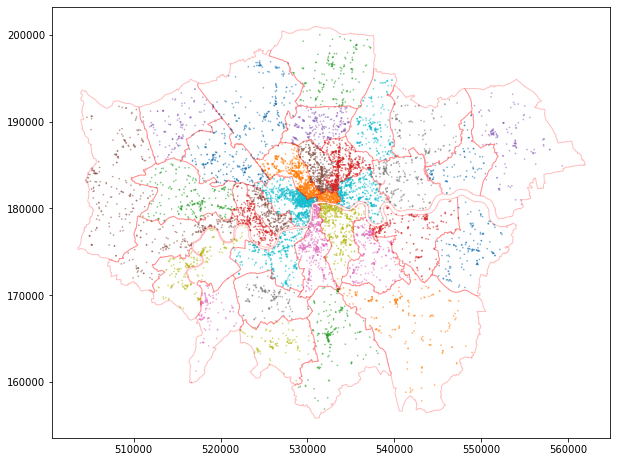

In [46]:
ax = gdf_culin.plot(column='BOROUGH', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.25);


### 4. Load Inside Airbnb Data


#### 4.1. Load Inside Airbnb listings data

In [31]:
url='https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/2021-10-10-listings.csv'

cols = ['id','name','price','latitude','longitude','room_type']

df_airbnb = pd.read_csv(url, usecols=cols, low_memory=False)
df_airbnb.shape
# df_airbnb.columns
# df_airbnb.sample(3)

(67903, 6)

In [32]:
# clean the data

df_airbnb['price'] = df_airbnb.price.astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)
print(df_airbnb.shape)

(67903, 6)


#### 4.2. Convert the dataframe into a GeoDataFrame

In [33]:
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude,
                                                       crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

#### 4.3.  Add Local Authority Names to Data
Associate Local Authority (LA) names to the listings using a spatial join:

In [34]:
gdf_la = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'room_type' 'price' 'geometry'
 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [35]:
print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

(67903, 13)


,id,name,NAME
53662,42409608,Cosy two bedroom home full of character,Merton
49155,39318693,Frills-free yet Clean and Comfortable Bedroom,Tower Hamlets
36922,29555250,Unmissable Luxurious Mews House in Central London,Westminster


#### 4.4. Tidy up

In [36]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Wandsworth', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Croydon', 'Southwark',
       'Waltham Forest', 'Brent', 'Camden', 'Newham', 'Tower Hamlets',
       'Lambeth', 'Hackney', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Ealing', 'Enfield', 'City of London',
       'Barking and Dagenham', 'Hillingdon', 'Harrow', 'Redbridge',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

#### 4.5. Map problematic listings

<AxesSubplot:>

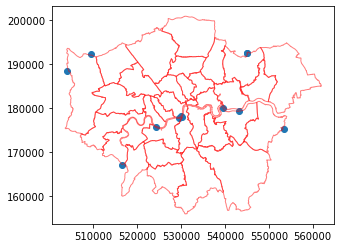

In [37]:
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

#### 4.6. Drop problematic listings

In [38]:
gdf_la.drop(index=gdf_airbnb[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(67891, 9)


#### 4.7. Check results

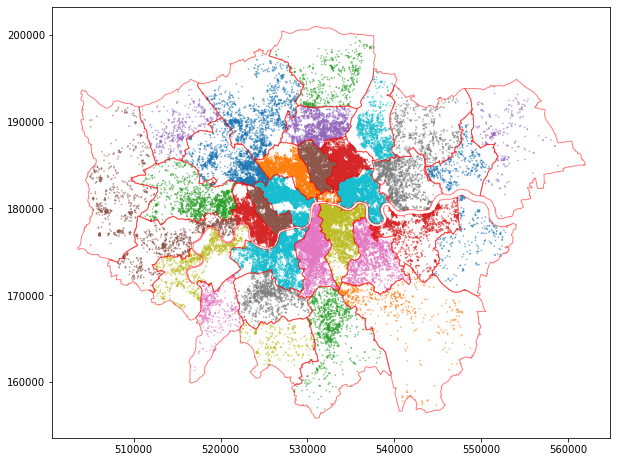

In [39]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

### 5. Exploring a Certain Local Authority

#### 5.1. Select an LA for exploring 

In [47]:
LA = 'Camden'

In [51]:
msoadf  = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            boros[msoas.Borough==LA], op='within')

NameError: name 'borous' is not defined

In [ ]:
msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

In [ ]:
msoa_gdf = msoagrdf.set_index('MSOA11NM').join(
                msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r')
msoa_gdf.head(3)

In [ ]:
msoa_gdf = msoa_gdf.set_geometry('geometry')
msoa_gdf.plot(column='median', legend=True, figsize=(8,8));

In [ ]:
f,axes = plt.subplots(1,2,figsize=(12,8))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

### 6. Hotel Data

#### 6.1. 

In [60]:
url = https://raw.githubusercontent.com/joeylizh/i2p/main/assessments/coursework3/cw_data/jsonstat.json

df_hotel = pd.read_csv(url, low_memory=False)
df_hotel.shape

SyntaxError: invalid syntax (675680262.py, line 1)